## 8 faces fine tuning 
In this nootebook we use a pretrained vgg16 network to extract features of the fc1 layer for the 8 faces dataset. Then we train a fully connected network with those features and our own labels.

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
import h5py
from scipy import misc
import os
import random

Loading features for the 8 faces dataset (because of computational reasons we just load them)

In [2]:
# Downloading the data, if it does not exist
import urllib
import os
if not os.path.isfile('8_faces_EMB.npz'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/3w3x9i7ng7017l3/8_faces_EMB.npz?dl=1",
    "8_faces_EMB.npz")
%ls -hl 8_faces_EMB.npz

-rw-r--r-- 1 root root 48M Mar 19 22:53 8_faces_EMB.npz


In [3]:
Data=np.load("8_faces_EMB.npz")
print(Data.files)
X_train = Data["arr_0"]
X_valid = Data["arr_1"]
X_test =  Data["arr_2"]
Y_train = Data["arr_3"]
Y_valid = Data["arr_4"]
Y_test =  Data["arr_5"]
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

['arr_1', 'arr_0', 'arr_3', 'arr_2', 'arr_5', 'arr_4']
(2000, 4096)
(400, 4096)
(2000,)
(400,)
(400, 4096)
(400,)


In [4]:
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='int32')
    result[np.arange(len(vector)), vector] = 1
    return result

In [5]:
Y_train=convertToOneHot(Y_train,num_classes=8)
Y_valid=convertToOneHot(Y_valid,num_classes=8)

In [6]:
batch_size = 128
nb_classes = 8
nb_epoch = 30

In [7]:
import keras
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.models import Sequential


Using TensorFlow backend.


#### Define the network

In [8]:
model = Sequential()
name = '8_faces_finetune'

model.add(Dense(400,init='he_normal',batch_input_shape=((None,4096))))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(400,init='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(nb_classes,init='he_normal'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 400)           1638800     dense_input_1[0][0]              
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 400)           1600        dense_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 400)           0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 400)           0           activation_1[0][0]               
___________________________________________________________________________________________

In [10]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir='tensorboard/8_faces/' + name + '/', 
        write_graph=True,
        histogram_freq=1)

#### Training the network


In [11]:
history=model.fit(X_train, Y_train, 
                  batch_size=batch_size, 
                  nb_epoch=nb_epoch,
                  verbose=1, 
                  validation_data=(X_valid, Y_valid),
                  callbacks=[tensorboard])

Train on 2000 samples, validate on 400 samples
INFO:tensorflow:Summary name dense_1_W:0 is illegal; using dense_1_W_0 instead.
INFO:tensorflow:Summary name dense_1_b:0 is illegal; using dense_1_b_0 instead.
INFO:tensorflow:Summary name batchnormalization_1_gamma:0 is illegal; using batchnormalization_1_gamma_0 instead.
INFO:tensorflow:Summary name batchnormalization_1_beta:0 is illegal; using batchnormalization_1_beta_0 instead.
INFO:tensorflow:Summary name batchnormalization_1_running_mean:0 is illegal; using batchnormalization_1_running_mean_0 instead.
INFO:tensorflow:Summary name batchnormalization_1_running_std:0 is illegal; using batchnormalization_1_running_std_0 instead.
INFO:tensorflow:Summary name dense_2_W:0 is illegal; using dense_2_W_0 instead.
INFO:tensorflow:Summary name dense_2_b:0 is illegal; using dense_2_b_0 instead.
INFO:tensorflow:Summary name batchnormalization_2_gamma:0 is illegal; using batchnormalization_2_gamma_0 instead.
INFO:tensorflow:Summary name batchnorma

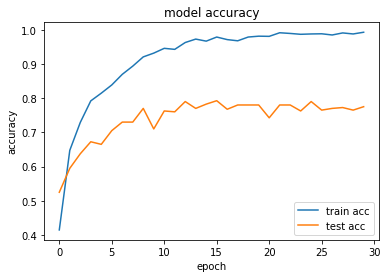

In [12]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train acc', 'test acc'], loc='lower right')
plt.show()

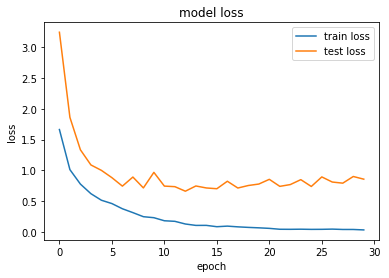

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'test loss'], loc='upper right')
plt.show()

#### Evaluation of the trained network


In [14]:
preds=np.zeros([len(X_test),8])
for i in range(0,len(X_test)):
    preds[i]=model.predict(X_test[i].reshape(1,4096))

In [15]:
pred=np.zeros([len(X_test)])
for i in range(0,len(X_test)):
    pred[i]=np.argmax(preds[i])

In [16]:
sum(pred==Y_test)/400.


0.83750000000000002

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, pred)

array([[41,  2,  1,  0,  0,  1,  5,  0],
       [ 0, 39,  0,  2,  2,  2,  4,  1],
       [ 0,  0, 48,  0,  0,  0,  1,  1],
       [ 0,  2,  0, 43,  0,  1,  3,  1],
       [ 0,  3,  0,  0, 43,  1,  3,  0],
       [ 0,  2,  1,  0,  0, 42,  5,  0],
       [ 3,  1,  1,  0,  0,  3, 41,  1],
       [ 0,  1,  6,  0,  0,  1,  4, 38]])

In [18]:
# Downloading the data, if it does not exist
if not os.path.isfile('Data_test_8_faces_no_cut_100_100.hdf5'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/1oe2cglv2xeb4bg/Data_test_8_faces_no_cut_100_100.hdf5?dl=1",
    "Data_test_8_faces_no_cut_100_100.hdf5")
%ls -hl Data_test_8_faces_no_cut_100_100.hdf5

-rw-r--r-- 1 root root 92M Mar 19 23:02 Data_test_8_faces_no_cut_100_100.hdf5


In [19]:
h5f_X = h5py.File('Data_test_8_faces_no_cut_100_100.hdf5', 'r')
print(list(h5f_X.keys()))
X_test = h5f_X['X_test_8_faces']
print(X_test.shape)
Y_test = h5f_X['Y_test_8_faces']
print(Y_test.shape)


['X_test_8_faces', 'Y_test_8_faces']
(400, 100, 100, 3)
(400,)


#### Visualize right and wrong classified images

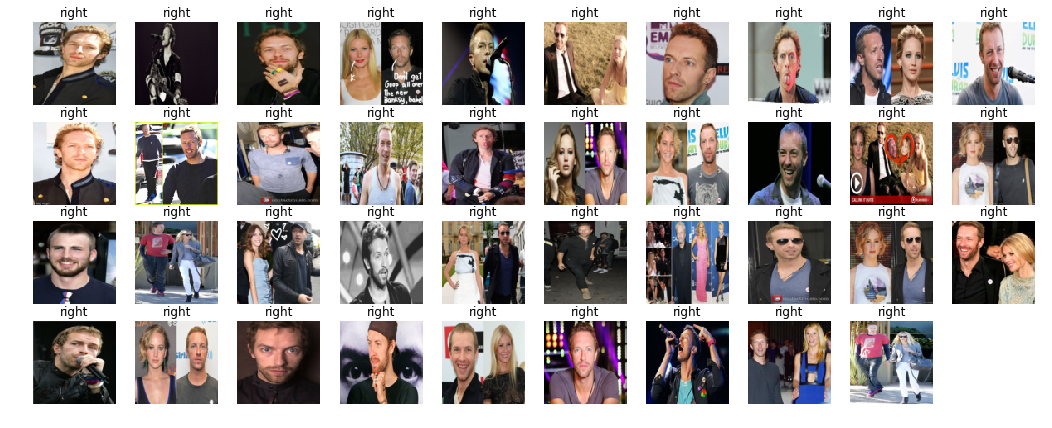

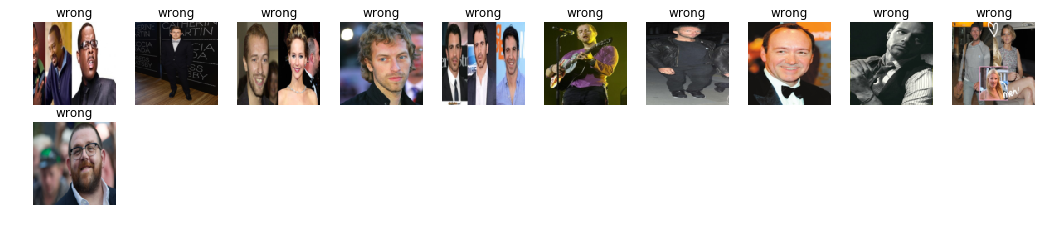

In [20]:
Klasse=1
right = np.where(Y_test[:]==Klasse)[0][np.where(np.in1d(np.where(Y_test[:]==Klasse),np.where(pred[:]==Klasse)))]
wrong = np.where(Y_test[:]==Klasse)[0][(np.in1d(np.where(Y_test[:]==Klasse),np.where(pred[:]==Klasse)))==False]

plt.figure(figsize=(18,18))
for i in range(0,len(right)):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.asarray(X_test[right[i]],dtype="uint8"))
    plt.axis('off')
    plt.title('right')
    
plt.figure(figsize=(18,18))
for i in range(0,len(wrong)):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.asarray(X_test[wrong[i]],dtype="uint8"))
    plt.axis('off')
    plt.title('wrong')